## Imports

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

## Load datasets and merge them

In [2]:
database = 'smogSensor.db'
conn = sqlite3.connect(database)

df0 = pd.read_sql("select * from sensor0", con = conn)
df1 = pd.read_sql("select * from sensor1", con = conn)
conn.close()

In [3]:
df0['date'] = pd.to_datetime(df0['date'])
df1['date'] = pd.to_datetime(df1['date'])

df0.sort_values('date', inplace = True)
df1.sort_values('date', inplace = True)

df0 = df0[['date', 'pm25', 'pm10', 'pressure', 'temperatureHeca', 'humidityHeca']]
df1 = df1[['date', 'pm25', 'pm10', 'temperatureSht', 'humiditySht', 'temperatureHeca', 'humidityHeca']]

df = pd.merge_asof(df0, df1, on = 'date', tolerance = pd.Timedelta('200s'))

## Clean data

#### Drop nulls, fail values

In [4]:
df.dropna(how = 'any',axis = 0, inplace = True)

#### Drop incorrect values (eg. debug messages)

In [5]:
error_idx = df[(df['pm25_x'] == -1)
              | (df['pm25_y'] == -1)
              | (df['pm10_x'] == -1)
              | (df['pm10_y'] == -1)
              | (df['pressure'] == 3)
              | (df['temperatureSht'] > 35.5) #several times the sensor was directly heated by the sun. The temperature was never above 35.5 degrees
              | (df['humidityHeca_x'] == 9)].index

In [6]:
df.drop(index = error_idx, inplace = True)

In [7]:
df = df.groupby([df.date.dt.floor('10min')]).mean()

#### Round values due to sensors accuracy

In [8]:
df['pm25_x'] = df['pm25_x'].round(1)
df['pm10_x'] = df['pm10_x'].round(1)
df['pressure'] = df['pressure'].round().astype(int)
df['temperatureHeca_x'] = df['temperatureHeca_x'].round(1)
df['humidityHeca_x'] = df['humidityHeca_x'].round().astype(int)
df['pm25_y'] = df['pm25_y'].round(1)
df['pm10_y'] = df['pm10_y'].round(1)
df['temperatureSht'] = df['temperatureSht'].round(1)
df['humiditySht'] = df['humiditySht'].round().astype(int)
df['temperatureHeca_y'] = df['temperatureHeca_y'].round(1)
df['humidityHeca_y'] = df['humidityHeca_y'].round().astype(int)

In [9]:
# Create columns with non-HECA to HECA ratio
df['pm25_ratio'] = (df['pm25_y'] / df['pm25_x']).round(2)
df['pm10_ratio'] = (df['pm10_y'] / df['pm10_x']).round(2)

In [10]:
df.reset_index(inplace = True)

#### Drop outliers

In [11]:
for col in ['date', 'pm25_x', 'pm10_x', 'pm25_y', 'pm10_y', 'temperatureSht']:
    df[f'{col}_diff'] = df[col].diff()

In [12]:
#keep only the ones that are within +5 to -5 standard deviations
df = df[
    (np.abs(df.pm25_ratio - df.pm25_ratio.mean()) <= (5 * df.pm25_ratio.std())) &
    (np.abs(df.pm10_ratio - df.pm10_ratio.mean()) <= (5 * df.pm10_ratio.std())) &
    (np.abs(df.pm25_x_diff - df.pm25_x_diff.mean()) <= (5 * df.pm25_x_diff.std())) &
    (np.abs(df.pm25_y_diff - df.pm25_y_diff.mean()) <= (5 * df.pm25_y_diff.std())) &
    (np.abs(df.pm10_x_diff - df.pm10_x_diff.mean()) <= (5 * df.pm10_x_diff.std())) &
    (np.abs(df.pm10_y_diff - df.pm10_y_diff.mean()) <= (5 * df.pm10_y_diff.std()))
     ]

In [13]:
avg_pm25_ratio = df[['humiditySht', 'pm25_ratio']]
avg_pm25_ratio['humiditySht'] = avg_pm25_ratio['humiditySht'].round()
avg_pm25_ratio = avg_pm25_ratio.groupby(['humiditySht']).mean()
avg_pm25_ratio.reset_index(inplace = True)

avg_pm10_ratio = df[['humiditySht', 'pm10_ratio']]
avg_pm10_ratio['humiditySht'] = avg_pm10_ratio['humiditySht'].round()
avg_pm10_ratio = avg_pm10_ratio.groupby(['humiditySht']).mean()
avg_pm10_ratio.reset_index(inplace = True)

<ipython-input-13-1da2aec13b42>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_pm25_ratio['humiditySht'] = avg_pm25_ratio['humiditySht'].round()
<ipython-input-13-1da2aec13b42>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_pm10_ratio['humiditySht'] = avg_pm10_ratio['humiditySht'].round()


## Non-dryer to dryer ratio

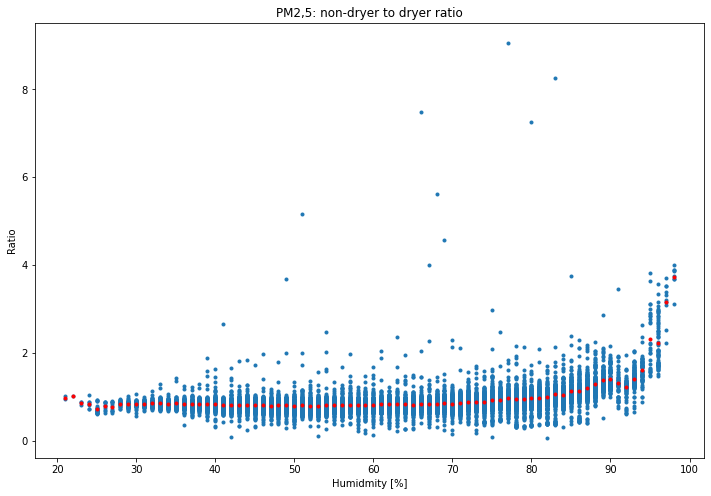

In [14]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)


plt.plot(df['humiditySht'], df['pm25_ratio'], '.', label = 'PM2,5 ratio')
plt.plot(avg_pm25_ratio['humiditySht'], avg_pm25_ratio['pm25_ratio'], 'r.', label = 'PM2,5 avg ratio')
plt.title('PM2,5: non-dryer to dryer ratio')
plt.xlabel('Humidmity [%]')
plt.ylabel('Ratio')

plt.show()

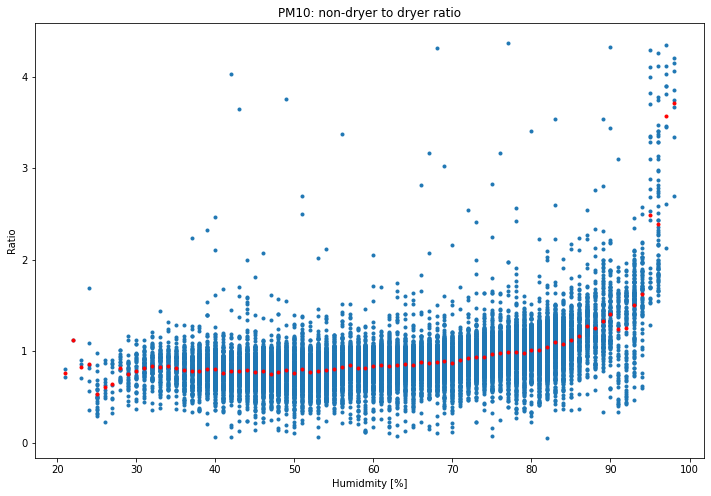

In [15]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)

plt.plot(df['humiditySht'], df['pm10_ratio'], '.', label = 'PM10 ratio')
plt.plot(avg_pm10_ratio['humiditySht'], avg_pm10_ratio['pm10_ratio'], 'r.', label = 'PM10 avg ratio')
plt.title('PM10: non-dryer to dryer ratio')
plt.xlabel('Humidmity [%]')
plt.ylabel('Ratio')

plt.show()